In [1]:
# Import lib
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import zarr
import zipfile
import os
import os
import zipfile
import xarray as xr
from tqdm import tqdm
import requests
import time
import json

## Download the original data

In [2]:
def download_with_progress(url, destination):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kilobyte

    with open(destination, 'wb') as file, tqdm(
        total=total_size, unit='iB', unit_scale=True, desc=destination, ncols=100, leave=True,
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"
    ) as bar:
        for data in response.iter_content(block_size):
            file.write(data)
            bar.update(len(data))

def get_version_1_of_seasfire_datacube(version='0.1'):
    try:
        # Download zipped cube

        if version == '0.1':
            url = "https://zenodo.org/records/6834585/files/SeasFireCube8daily.zip"
            zip_filename = "SeasFireCube8daily.zip"
        elif version == '0.4':
            url = "https://zenodo.org/records/13834057/files/seasfire_v0.4.zip"
            zip_filename = "SeasFireCube8daily_v0.4.zip"

        if not os.path.exists(zip_filename):
            print("Downloading data cube...")
            download_with_progress(url, zip_filename)
        else:
            print("Data cube already downloaded.")

        # Extract from zip file with progress bar
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            print("Extracting data cube...")
            total_files = len(zip_ref.namelist())
            with tqdm(total=total_files, unit='file', desc='Extracting', ncols=100, leave=True,
                      bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]") as bar:
                for file in zip_ref.namelist():
                    zip_ref.extract(file)
                    bar.update(1)

        if version == '0.1':
            extracted_folder = 'SeasFireCube8daily.zarr'
        elif version == '0.4':
            extracted_folder = 'SeasFireCube8daily_v0.4.zarr'
            
        if not os.path.exists(extracted_folder):
            raise FileNotFoundError(f"Extraction failed, {extracted_folder} not found.")

        # Load dataset
        dataset = xr.open_zarr(extracted_folder)
        print("Dataset successfully loaded.")
        return dataset

    except Exception as e:
        print(f"An error occurred while downloading or loading the data cube: {e}")
        return None

dataset = get_version_1_of_seasfire_datacube(version='0.1')

Data cube already downloaded.
Extracting data cube...


Extracting: 100%|███████████████████████████████████████████████| 680/680 [00:22<00:00, 30.03file/s]

Dataset successfully loaded.



/tmp/ipykernel_2232596/3683060583.py:52: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  dataset = xr.open_zarr(extracted_folder)


In [3]:
dataset

<xarray.Dataset> Size: 140GB
Dimensions:             (time: 966, latitude: 720, longitude: 1440)
Coordinates:
  * time                (time) datetime64[ns] 8kB 2001-01-01T12:00:00 ... 202...
  * latitude            (latitude) float64 6kB 89.88 89.62 ... -89.62 -89.88
  * longitude           (longitude) float64 12kB -179.9 -179.6 ... 179.6 179.9
Data variables: (12/35)
    swvl1               (time, latitude, longitude) float32 4GB ...
    mslp                (time, latitude, longitude) float32 4GB ...
    fwi                 (time, latitude, longitude) float32 4GB ...
    ea                  (time, latitude, longitude) float32 4GB ...
    ssr                 (time, latitude, longitude) float32 4GB ...
    pna                 (time, latitude, longitude) float32 4GB ...
    ...                  ...
    rH_cf               (time, latitude, longitude) float32 4GB ...
    wp                  (time, latitude, longitude) float32 4GB ...
    FCD_emissions       (time, latitude, longitude) float32 4GB ...
    ssrd                (time, latitude, longitude) float32 4GB ...
    BAs_GWIS            (time, latitude, longitude) float32 4GB ...
    ws10                (time, latitude, longitude) float32 4GB ...

## Data processing functions 

(functions from the given ipynb)

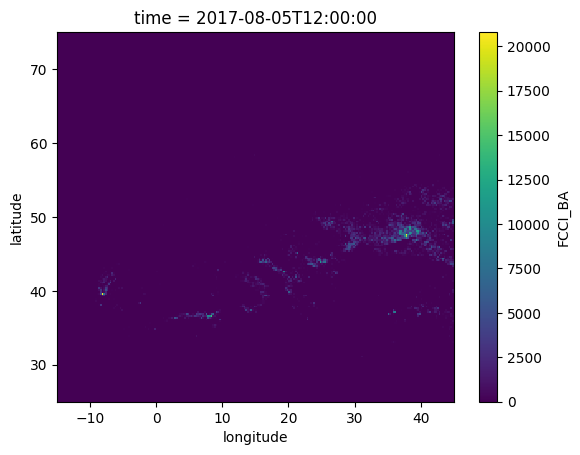

In [4]:
def select_spatio_temporal_data(dataset, initial_timestep, timesteps, latitude, longitude):
    '''
    Desc
    ----
    Method to select a subset of the cube.

    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    latitude: int
        * vallue in the interval [0,719] where value represents the position of the latitude we want in the latitude array
        * if we want all the latitudes, we set the value = -1
    longitude: int
        * vallue in the interval [0,14time_lag] where value represents the position of the longitude we want in the longitude array
        * if we want all the longitudes, we set the value = -1
    '''

    if(latitude == -1 and longitude == -1):
        return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps))
    elif len(latitude)==2 and longitude == -1:
        return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps), latitude=slice(latitude[0], latitude[1]))
    elif len(longitude)==2 and latitude == -1:
        return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps), longitude=slice(longitude[0], longitude[1]))
    elif len(latitude)==2 and len(longitude)==2:
        return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps), latitude=slice(latitude[0], latitude[1]), longitude=slice(longitude[0], longitude[1]))
    else:
        return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps), latitude=latitude, longitude=longitude)


def earth_graph(dataset, initial_timestep, timesteps, latitude=-1, longitude=-1, col_wrap=1, plot=True):
    '''
    Desc
    ----
    Method to plot whole earth for specific variable for specific time interval.

    Args
    ----
    dataset: xarray.Dataset
        * the dataset from which we want the selected variable
    variable name: string
        * name of the selected variable
    initial_timestep: int
        * value in the interval [0,965], where value represents the position of the date we want in the time array
        * shows from what 8-day period we want to extract the data
    timesteps: int
        * value in the interval [1,966]
        * shows for how many consecutive 8-days periods we want to extract the data
    col_wrap: int
        *how many graphs will be plotted i the same row
    latitude: int
        * value = -1, that is whole earth
    longitude: int
        * value = -1, that is whole earth
    '''
    if plot:
        if (timesteps==1):

            select_spatio_temporal_data(dataset,
                                        initial_timestep,
                                        timesteps,
                                        latitude,
                                        longitude).plot()
        else:
            select_spatio_temporal_data(dataset,
                                        initial_timestep,
                                        timesteps,
                                        latitude,
                                        longitude).plot(x="longitude",
                                                        y="latitude",
                                                        col="time",
                                                        col_wrap=col_wrap)
    else:
        if (timesteps==1):
            return select_spatio_temporal_data(dataset,
                                               initial_timestep,
                                               timesteps,
                                               latitude,
                                               longitude)
        else:
            return select_spatio_temporal_data(dataset,
                                               initial_timestep,
                                               timesteps,
                                               latitude,
                                               longitude)

latitude = ['25N', '75N']
longitude = ['15W', '45E']

Burnt_area = 'BAs_GWIS'

def latitude_to_index(lat):
    if lat[-1] == 'N':
        return int((90 - float(lat[:-1])) / 180 * 720)
    elif lat[-1] == 'S':    
        return int((float(lat[:-1]) + 90) / 180 * 720)

def longitude_to_index(lon):
    if lon[-1] == 'W':
        return int((180 - float(lon[:-1])) / 360 * 1440)
    elif lon[-1] == 'E':    
        return int((float(lon[:-1]) + 180) / 360 * 1440)

def latitude2index(latitude):
    return np.sort(np.array([latitude_to_index(lat) for lat in latitude])).tolist()
def longitude2index(longitude):
    return np.sort(np.array([longitude_to_index(lon) for lon in longitude])).tolist()

earth_graph(dataset['FCCI_BA'], 763, 1, latitude2index(latitude), longitude2index(longitude))

## Generate the train/val/test .json files under data folder

In [5]:
def sample_new_coords(shape, existing_coords, N):
    """
    Randomly sample N distinct coordinates in an array of given shape,
    excluding any in existing_coords.

    Parameters
    ----------
    shape : tuple of ints
        The overall grid shape, e.g. (100,100,100).
    existing_coords : ndarray of shape (M, ndim)
        Integer coordinates to exclude.
    N : int
        Number of new coordinates to sample.

    Returns
    -------
    new_coords : ndarray of shape (N, ndim)
        The newly sampled coordinates.
    """
    shape = tuple(shape)
    ndim = len(shape)

    # 1) convert existing coords to flat indices
    #    (coords.T gives a tuple of arrays for each dimension)
    flat_existing = np.ravel_multi_index(existing_coords.T, shape)

    # 2) total number of points
    total = np.prod(shape)

    # 3) build the set of available flat indices
    #    (assume existing are unique -> faster)
    all_flat = np.arange(total)
    unused_flat = np.setdiff1d(all_flat, flat_existing, assume_unique=True)

    if N > unused_flat.size:
        raise ValueError(f"Cannot sample {N} points; only {unused_flat.size} free.")

    # 4) choose N of them without replacement
    chosen_flat = np.random.choice(unused_flat, size=N, replace=False)

    # 5) map back to nd-coordinates
    new_coords = np.column_stack(np.unravel_index(chosen_flat, shape))
    return new_coords


def build_dataset(type='train', latitude=['25N', '75N'], longitude=['15W', '45E'], NPR=5, fire_threshold=20000, time_lag=39, fire_var='BAs_GWIS', local_var=("t2m", "tp", "vpd_cf"), ocis=("nao", "nina34_anom")):

    # 1) decide time ranges
    if type == 'train':
        initial_t, total_steps = 0, 46 * 17
    elif type == 'test':
        initial_t, total_steps = 46 * 17, 46 * 2
    elif type == 'val':
        initial_t, total_steps = 46 * 19, 46 * 2
    else:
        raise ValueError("Invalid type. Choose 'train','test','val'.")

    lat_idx = latitude2index(latitude)
    lon_idx = longitude2index(longitude)

    core_start = initial_t + time_lag
    core_len   = total_steps - time_lag

    # 2) load fire and predictors ONCE
    fire_arr = select_spatio_temporal_data(dataset[fire_var], core_start, core_len, lat_idx, lon_idx).values

    local_arrs = {
        v: select_spatio_temporal_data(dataset[v], initial_t, total_steps, lat_idx, lon_idx).values
        for v in local_var
    }
    oci_arrs = {
        v: select_spatio_temporal_data(dataset[v], initial_t, total_steps, lat_idx, lon_idx).values
        for v in ocis
    }

    # 3) find positives & sample negatives
    flat = fire_arr.ravel()
    pos_flat = np.nonzero(flat > fire_threshold)[0]
    pos_coords = np.column_stack(np.unravel_index(pos_flat, fire_arr.shape))
    neg_coords = sample_new_coords(fire_arr.shape, pos_coords, NPR * len(pos_coords))

    # 4) build output
    out = []
    for coords, label, desc in ((pos_coords,1,"pos"), (neg_coords,0,"neg")):
        pbar = tqdm(coords, desc=f"Processing {desc}", unit="pt")
        for t_rel, y, x in pbar:
            t_abs   = core_start + int(t_rel)
            rel_idx = t_abs - initial_t       # now in  [0 .. total_steps)
            t0, t1 = rel_idx - time_lag, rel_idx

            # Nested structure
            inst = {"local_variables": {}, "ocis": {}, "target": label}

            # fill local_variables with UPPERCASE keys
            for v, arr in local_arrs.items():
                key = v.upper()
                inst["local_variables"][key] = arr[t0:t1, y, x].tolist()

            # fill ocis with UPPERCASE keys
            for v, arr in oci_arrs.items():
                key = v.upper()
                inst["ocis"][key] = arr[t0:t1, y, x].tolist()

            out.append(inst)

    import random
    random.shuffle(out)

    with open(f"./data/{type}.json", "w", encoding="utf-8") as f:
        for inst in out:
            f.write(
                json.dumps(inst, ensure_ascii=False, separators=(',', ':'))
                + "\n"
            )
    print(f"Dataset saved to {type}.json (NDJSON, one object per line)")

#### .json file generator.

Fire data is continuous variable. The fire_threshold can transform the continuous fire area variable to the binary status. Smaller fire_threshold, larger .json file created.

In [6]:
# For real implementation, suggest the fire_threshold to be 1.

build_dataset(type='train', fire_threshold=5000)
build_dataset(type='val', fire_threshold=5000)
build_dataset(type='test', fire_threshold=5000)

Processing neg: 100%|██████████| 6400/6400 [00:00<00:00, 43038.85pt/s]



Dataset saved to train.json (NDJSON, one object per line)


Processing neg: 100%|██████████| 5/5 [00:00<00:00, 60262.99pt/s]



Dataset saved to val.json (NDJSON, one object per line)


Processing neg: 100%|██████████| 580/580 [00:00<00:00, 96951.07pt/s]

Dataset saved to test.json (NDJSON, one object per line)


## Dataset and Dataloader

In [7]:
import json
import torch
from torch.utils.data import Dataset, DataLoader

class JsonFireDataset(Dataset):
    def __init__(self, json_path, local_keys=None, oci_keys=None):
        """
        Args:
            json_path (str): path to your NDJSON file (one JSON object per line).
            local_keys (list of str): names of the local_variables channels, e.g. ['T2M','TP','VPD_CF'].
                                      If None, inferred from the first sample.
            oci_keys   (list of str): names of the ocis channels, e.g. ['NAO','NINA34_ANOM'].
                                      If None, inferred from the first sample.
        """
        # load all lines
        with open(json_path, 'r', encoding='utf-8') as f:
            self.records = [json.loads(line) for line in f]

        # infer channel order if not given
        first = self.records[0]
        if local_keys is None:
            local_keys = list(first['local_variables'].keys())
        if oci_keys is None:
            oci_keys = list(first['ocis'].keys())

        self.local_keys = local_keys
        self.oci_keys   = oci_keys
        self.channel_keys = self.local_keys + self.oci_keys

        # sanity-check that every record has the same length L
        L = len(first['local_variables'][self.local_keys[0]])
        for rec in self.records:
            assert all(len(rec['local_variables'][k]) == L for k in self.local_keys), "inconsistent L"
            assert all(len(rec['ocis'][k]) == L for k in self.oci_keys),       "inconsistent L"
        self.L = L

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec = self.records[idx]

        # collect each channel sequence into a list
        seqs = []
        for k in self.local_keys:
            seqs.append(rec['local_variables'][k])
        for k in self.oci_keys:
            seqs.append(rec['ocis'][k])

        # stack → shape (channel, L)
        x = torch.tensor(seqs, dtype=torch.float32)
        y = torch.tensor(rec['target'], dtype=torch.long)
        return x, y

# ── USAGE ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # point these to your actual JSON file
    train_ds = JsonFireDataset(
        "./data/train.json",
        local_keys=["T2M","TP","VPD_CF"],
        oci_keys=["NAO","NINA34_ANOM"],
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=2048,
        shuffle=True,
        num_workers=4,    # adjust to your machine
        pin_memory=True,  # if you’re on GPU
    )

    # iterate
    for batch_x, batch_y in train_loader:
        # batch_x: (32, 5, L)
        # batch_y: (32,)
        print(batch_x.shape, batch_y.shape)
        break


torch.Size([2048, 5, 39]) torch.Size([2048])


## Others, delete in the final version

In [8]:
data = earth_graph(dataset['BAs_GWIS'], 0, 100, latitude2index(latitude), longitude2index(longitude), plot=False)

(100, 200, 240)


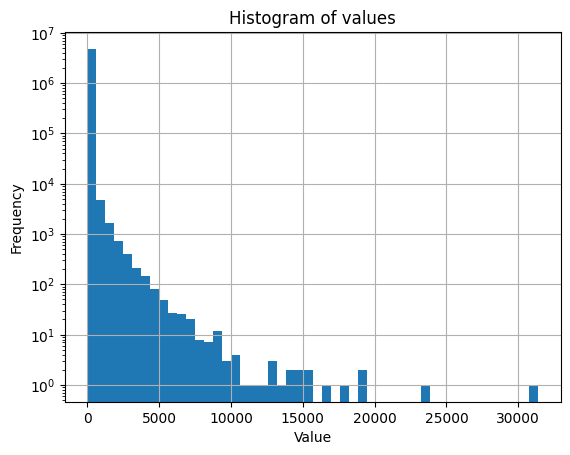

In [9]:
print(data.values.shape)
arr_1d = data.values.reshape(-1)  # or use arr.ravel()

# Plot histogram
plt.hist(arr_1d, bins=50, log=True)
plt.title("Histogram of values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()